# Code to train linear ML model 
This notebook was made on Google Colab ([link to notebook](https://colab.research.google.com/drive/1v9TvoMjIgbUIj1Mna2setqvZNuOrSbXv?usp=sharing)). If you are running on your local machine remove the cells related to data retrieval and RDKit installation, and change the paths to the files as needed.


# Software installation and data retrieval, etc.


In [1]:
%%capture
# Install RDKit
# takes 2-3 minutes
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

In [2]:
# Download training data
! rm -f linear_ml_density_train_data.csv linear_ml_barrier_train_data.csv
! wget https://sid.erda.dk/share_redirect/EwaEr2JMrb/all_230_billion/ml_data/linear_ml_density_train_data.csv
! wget https://sid.erda.dk/share_redirect/EwaEr2JMrb/all_230_billion/ml_data/linear_ml_barrier_train_data.csv

--2020-07-03 09:00:59--  https://sid.erda.dk/share_redirect/EwaEr2JMrb/all_230_billion/ml_data/linear_ml_density_train_data.csv
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10918996 (10M) [text/csv]
Saving to: ‘linear_ml_density_train_data.csv’

linear_ml_density_t 100%[===================>]  10.41M  7.32MB/s    in 1.4s    

2020-07-03 09:01:01 (7.32 MB/s) - ‘linear_ml_density_train_data.csv’ saved [10918996/10918996]

--2020-07-03 09:01:02--  https://sid.erda.dk/share_redirect/EwaEr2JMrb/all_230_billion/ml_data/linear_ml_barrier_train_data.csv
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2565910 (2.4M) [text/csv]
Saving to: ‘linear_ml_barrier_train_data.csv’

linear_ml_barrier_t 100%[===================>]   2.45M 

In [3]:
import sys
import re
import pandas as pd 
import numpy as np

from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns

# RDKit
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem
from rdkit.Chem import Descriptors

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
plt.rcParams['xtick.labelsize'] = 16 
plt.rcParams['ytick.labelsize'] = 16 
plt.rcParams['axes.labelsize'] = 16

# Helper Functions
Functions to make RDKit object and the find number of substituents from gene names.

In [5]:
ligands = ['H', 'F', 'Cl', 'Br', 'C(F)(F)(F)', 'C#N',
           '[N+](=O)([O-])', 'C(=O)[H]', 'C(=O)O',
           'C(=O)C', 'C(=O)N', 'C#C', 'S(=O)(=O)(C)',
           'C=N', 'O', 'OC', 'N', 'N(C)(C)', 'C',
           'N(C(=O)(C))', 'SC', 'C3=CC=C(F)C=C3',
           'C3=CC=C(Cl)C=C3', 'C3=CC=C(Br)C=C3',
           'C3=CC=C(C(F)(F)(F))C=C3',
           'C3=CC=C(C#N)C=C3', 'C3=CC=C([N+](=O)([O-]))C=C3',
           'C3=CC=C(C(=O)[H])C=C3', 'C3=CC=C(C(=O)O)C=C3',
           'C3=CC=C(C(=O)C)C=C3', 'C3=CC=C(C(=O)N)C=C3',
           'C3=CC=C(C#C)C=C3', 'C3=CC=C(S(=O)(=O)(C))C=C3',
           'C3=CC=C(C=N)C=C3', 'C3=CC=C(O)C=C3',
           'C3=CC=C(OC)C=C3', 'C3=CC=C(N)C=C3',
           'C3=CC=C(N(C)(C))C=C3', 'C3=CC=C(C)C=C3',
           'C3=CC=C(N(C(=O)(C)))C=C3', 'C3=CC=C(SC)C=C3',
           'C3=CC=CC=C3']


ligand_num2smiles = OrderedDict(zip(list(range(len(ligands))),ligands))

def get_mol(gene):
    global ligands

    gene = gene.split('-')
    
    core = 'N#CC1(C#N)C(1)=C(2)C2=C(3)C(4)=C(5)C(6)=C(7)C21'
    
    gene_smiles = core
    for i, ligand_idx in enumerate(gene):
        substr = ligands[int(ligand_idx)]
        if substr == 'H':
            continue
        gene_smiles = gene_smiles.replace('('+str(i+1)+')', f'({substr})')
    
    mol = Chem.MolFromSmiles(re.sub('\([0-9]\)', '', gene_smiles))

    return mol

def num_subs(gene):
    gene = [int(x) for x in gene.split('-')]
    return 7 - gene.count(0)

def get_smiles(rdkit_mol):
    return Chem.MolToSmiles(Chem.RemoveHs(rdkit_mol))

# Train Linear Regression Model - Density

## Prepare Data

In [6]:
df_density = pd.read_csv('linear_ml_density_train_data.csv')

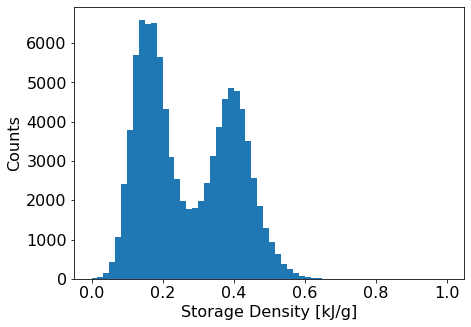

In [7]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
ax.hist(df_density['xtb_density'], bins=60, range=(0,1), label='All Density Data')

ax.set(xlabel='Storage Density [kJ/g]', ylabel='Counts');

## Split into two models
Train two different models. One that predicts on 1-4 subs, and another for 5-7 subs.

In [8]:
df1 = df_density.loc[df_density['num_subs'].isin([1])].copy()

df24 = df_density.loc[df_density['num_subs'].isin([2,3,4])].copy()
df57 = df_density.loc[df_density['num_subs'].isin([5,6,7])].copy()

In [9]:
df_train57, df_test57 =  train_test_split(df57, test_size=0.5, random_state=80)
df_test57 = df_test57.copy()

# Add all ones to 2-4 subs
df_train24, df_test24 =  train_test_split(df24, test_size=0.5, random_state=80)
df_train24 = pd.concat([df_train24, df1])
df_train24 = df_train24.copy()

print(f"train 5-7: {df_train57.shape[0]}, test2-4: {df_test57.shape[0]}")
print(f"train 2-4: {df_train24.shape[0]}, test5-7: {df_test24.shape[0]}")

train 5-7: 25940, test2-4: 25940
train 2-4: 22158, test5-7: 21884


## Train Model

In [10]:
def one_hot(gene):
    """Creates one-hot representation"""
    one_hot = np.zeros((7,41), dtype=np.float32)
    for i, base in enumerate([int(x) for x in gene.split('-')]):
        if base == 0:
            continue
        one_hot[i,base - 1] = 1.
    return one_hot

def training_data_one_hot(df, prop='xtb_density'):
    """ Create Matrices and Vectors with representation and targets repectively """
    Xs = np.empty((df.shape[0], 287))
    ys = np.empty(df.shape[0])
    
    for i, row in enumerate(df.itertuples()):
        Xs[i] = one_hot(row.gene).flatten()
        ys[i] = getattr(row, prop)
    
    return Xs, ys

In [11]:
# Predict 2-4
Xtrain24_s, ytrain24_s = training_data_one_hot(df_train24, prop='xtb_density')
reg_s24 = LinearRegression().fit(X=Xtrain24_s, y=ytrain24_s)

Xtest24_s, ytest24_s = training_data_one_hot(df_test24, prop='xtb_density')
ypred_24 = reg_s24.predict(Xtest24_s)
df_test24['pred_density'] = ypred_24 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [12]:
# Predict 5-7
Xtrain57_s, ytrain57_s = training_data_one_hot(df_train57, prop='xtb_density')
reg_s57 = LinearRegression().fit(X=Xtrain57_s, y=ytrain57_s)

Xtest57_s, ytest57_s = training_data_one_hot(df_test57, prop='xtb_density')
ypred_57 = reg_s57.predict(Xtest57_s)
df_test57['pred_density'] = ypred_57

## Make Figure S4

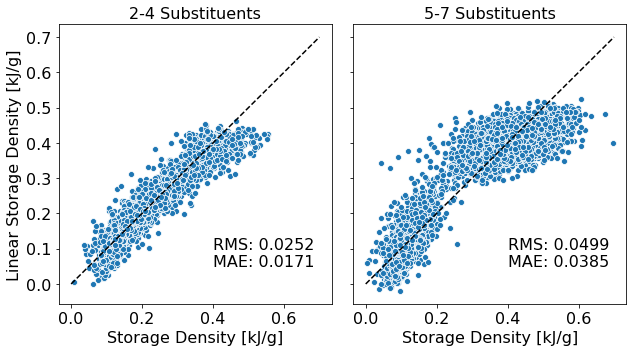

In [13]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(9,5), sharey=True)

num_samples = 8000

# Plot 2-4 subs
sns.scatterplot(x='xtb_density', y='pred_density', data=df_test24.sample(num_samples, random_state=31), ax=ax[0])

error24 = df_test24.pred_density - df_test24.xtb_density
mae = abs(error24).mean()
rms = (error24).std()

ax[0].plot([0.0,0.7], [0.0,0.7], '--k')
ax[0].set_title('2-4 Substituents', fontsize=16)
ax[0].set(xlabel='Storage Density [kJ/g]', ylabel='Linear Storage Density [kJ/g]')

s24 = f'RMS: {rms:.4f} \nMAE: {mae:.4f}'
ax[0].text(0.4,0.05, s24, {'fontsize': 16});

# Plot 5-7 subs
sns.scatterplot(x='xtb_density', y='pred_density', data=df_test57.sample(num_samples, random_state=31), ax=ax[1])

error57 = df_test57.pred_density - df_test57.xtb_density
mae = abs(error57).mean()
rms = (error57).std()

ax[1].plot([0.0,0.7], [0.0,0.7], '--k')
ax[1].set_title('5-7 Substituents', fontsize=16)
ax[1].set(xlabel='Storage Density [kJ/g]', ylabel='Linear Storage Density [kJ/g]')

s57 = f'RMS: {rms:.4f} \nMAE: {mae:.4f}'
ax[1].text(0.4,0.05, s57, {'fontsize': 16});

fig.tight_layout()

# Train Linear Regression Model - Barrier 
Only for testing GA.

## Prepare Data

In [14]:
df_barrier = pd.read_csv('linear_ml_barrier_train_data.csv')
df_barrier.head()

,gene,num_subs,smiles,pm3_barrier
0,0-0-6-0-0-0-0,1,N#CC1(C#N)C=CC2=C([N+](=O)[O-])C=CC=CC21,195.204558
1,0-0-0-0-25-0-0,1,N#Cc1ccc(C2=CC=C3C=CC(C#N)(C#N)C3C=C2)cc1,186.308338
2,0-0-0-0-0-0-20,1,CSC1=CC=CC=C2C=CC(C#N)(C#N)C21,195.950349
3,0-36-0-0-0-0-0,1,N#CC1(C#N)C=C(c2ccc(N)cc2)C2=CC=CC=CC21,163.975406
4,0-0-0-0-33-0-0,1,N#CC1(C#N)C=CC2=CC=C(c3ccc(C=N)cc3)C=CC21,183.751149


How many samples for each number of subs?

In [15]:
df_barrier[['gene', 'num_subs']].groupby("num_subs").count()

,gene
num_subs,
1,262
2,927
3,4497
4,4316
5,2294
6,5861
7,3748


## Train Model

In [16]:
# Split Data
df_train_barrier, df_test_barrier = train_test_split(df_barrier, test_size=0.2, random_state=42)

df_train_barrier = pd.concat([df_train_barrier, df_test_barrier.loc[df_test_barrier["num_subs"] == 1]])
df_test_barrier =  df_test_barrier.loc[df_test_barrier["num_subs"] != 1]

print(f"train: {df_train_barrier.shape[0]}, test: {df_test_barrier.shape[0]}")

train: 17567, test: 4338


In [17]:
# Train Model
Xtrain_b, ytrain_b = training_data_one_hot(df_train_barrier, prop='pm3_barrier')
reg_barrier = LinearRegression().fit(X=Xtrain_b, y=ytrain_b)

# Predict on test
Xtest_b, ytest_b = training_data_one_hot(df_test_barrier, prop='pm3_barrier')
ypred_b = reg_barrier.predict(Xtest_b)

df_test_barrier["pred_barrier"] = ypred_b

## Make Figure S6

In [18]:
# Compute error
error = df_test_barrier["pred_barrier"] - df_test_barrier['pm3_barrier']

mae = abs(error).mean()
rms = error.std()

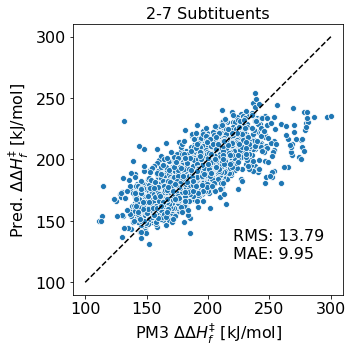

In [19]:
fig2, ax2 = plt.subplots(ncols=1, nrows=1, figsize=(5,5))

sns.scatterplot(x="pm3_barrier", y="pred_barrier", data=df_test_barrier)
ax2.plot([100,300], [100,300], '--k')

ax2.set_title('2-7 Subtituents', fontsize=16)
ax2.set(xlabel=r'PM3 $\Delta \Delta H_f^{\ddag}$ [kJ/mol]', ylabel='Pred. $\Delta \Delta H_f^{\ddag}$ [kJ/mol]')

s_barrier = f'RMS: {rms:.2f} \nMAE: {mae:.2f}'
ax2.text(220,120, s_barrier, {'fontsize': 16});

fig2.tight_layout()